In [5]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

In [6]:
# Parameters
lambd = 3.36251543
rho = 0.19183673
u0 = 0.12950433
gamma1 = 1
output_min=0.058579
output_max=0.259033

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Running with layers [1, 40, 60, 20, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 0
Number of failed models: 15
Average differences for with [1, 40, 60, 20, 1] layers:
Average Difference: t=0: 0.00064090, t=0.5: 0.00097271, t=1: 0.00069527
Total Training Time for [1, 40, 60, 20, 1]: 20.48 minutes, Average Train Time: 81.90 seconds


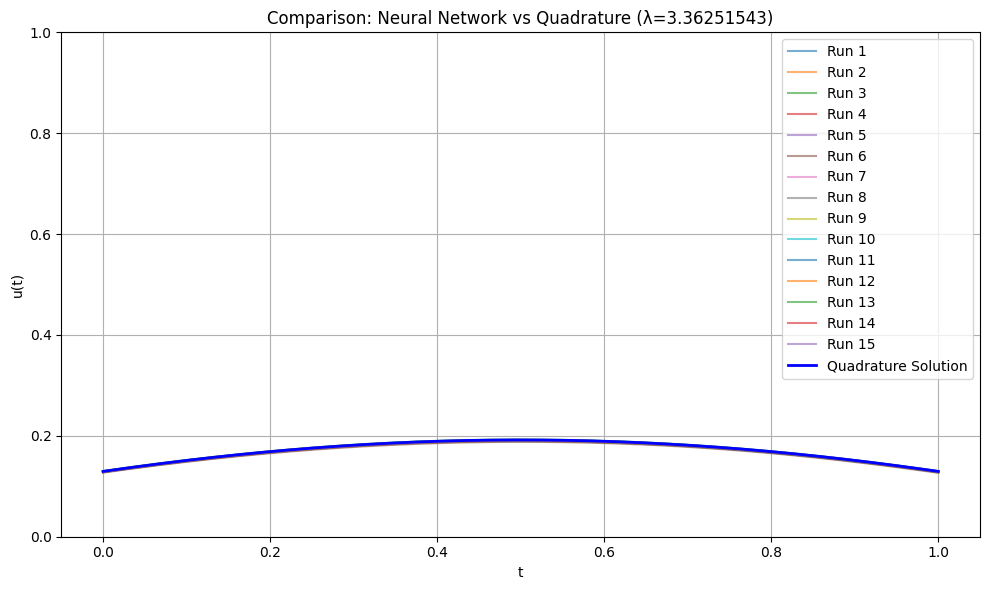

Running with layers [1, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 0
Number of failed models: 15
Average differences for with [1, 16, 16, 1] layers:
Average Difference: t=0: -0.00105064, t=0.5: -0.00138858, t=1: -0.00102413
Total Training Time for [1, 16, 16, 1]: 15.02 minutes, Average Train Time: 60.09 seconds


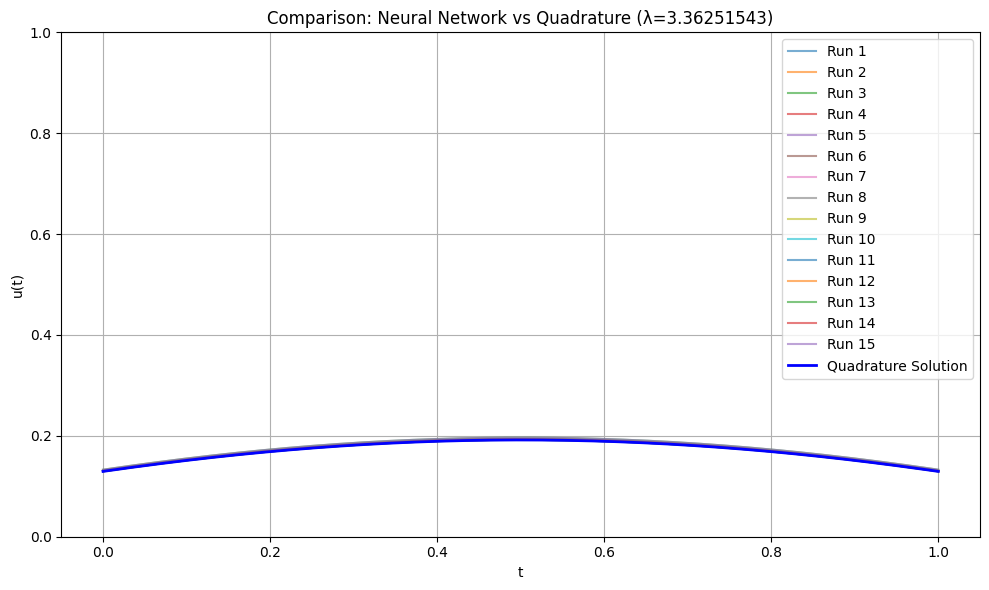

Running with layers [1, 16, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 0
Number of failed models: 15
Average differences for with [1, 16, 16, 16, 1] layers:
Average Difference: t=0: 0.00035711, t=0.5: 0.00056494, t=1: 0.00039193
Total Training Time for [1, 16, 16, 16, 1]: 19.40 minutes, Average Train Time: 77.59 seconds


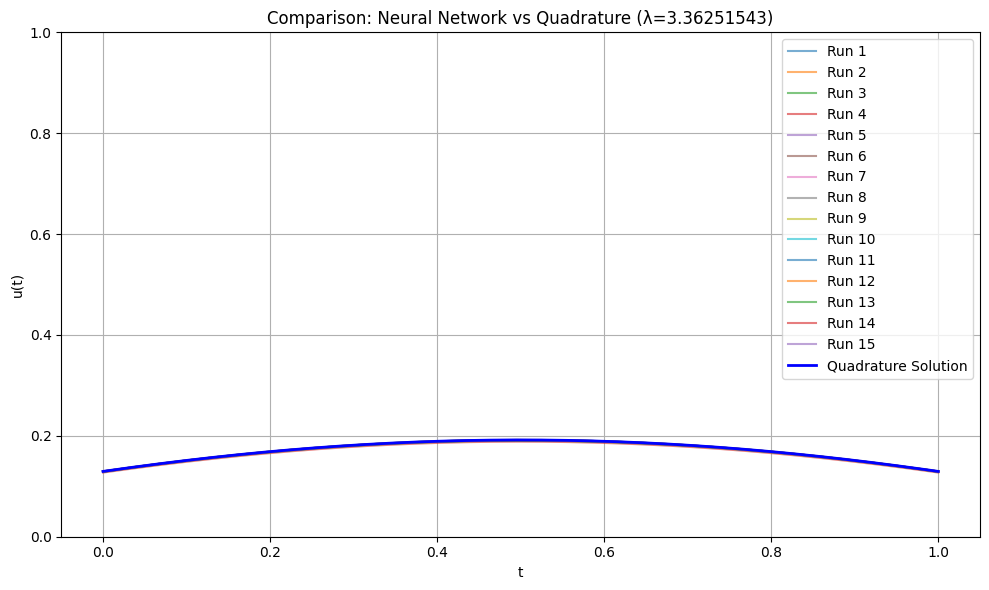

Running with layers [1, 16, 16, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 0
Number of failed models: 15
Average differences for with [1, 16, 16, 16, 16, 1] layers:
Average Difference: t=0: 0.00098590, t=0.5: 0.00146403, t=1: 0.00099111
Total Training Time for [1, 16, 16, 16, 16, 1]: 24.05 minutes, Average Train Time: 96.18 seconds


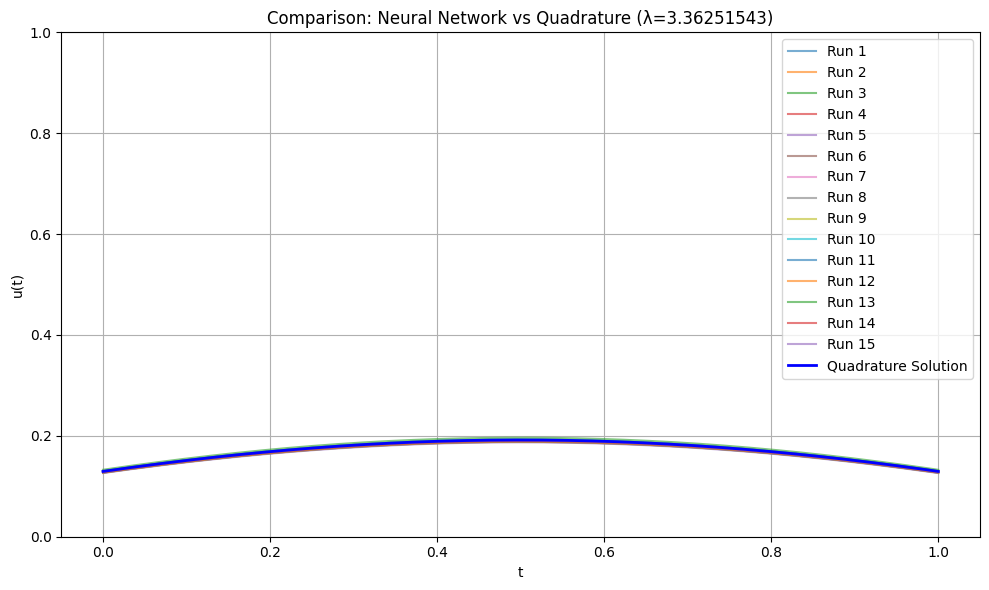

Running with layers [1, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 0
Number of failed models: 15
Average differences for with [1, 32, 32, 1] layers:
Average Difference: t=0: -0.00032437, t=0.5: -0.00046100, t=1: -0.00033524
Total Training Time for [1, 32, 32, 1]: 14.85 minutes, Average Train Time: 59.42 seconds


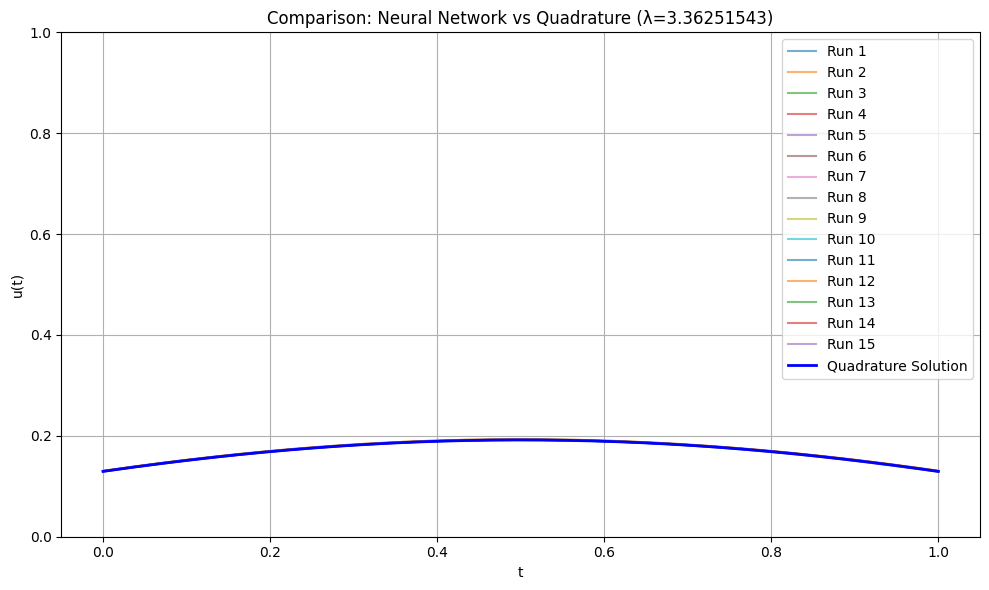

Running with layers [1, 32, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 0
Number of failed models: 15
Average differences for with [1, 32, 32, 32, 1] layers:
Average Difference: t=0: 0.00030715, t=0.5: 0.00046654, t=1: 0.00024388
Total Training Time for [1, 32, 32, 32, 1]: 19.24 minutes, Average Train Time: 76.95 seconds


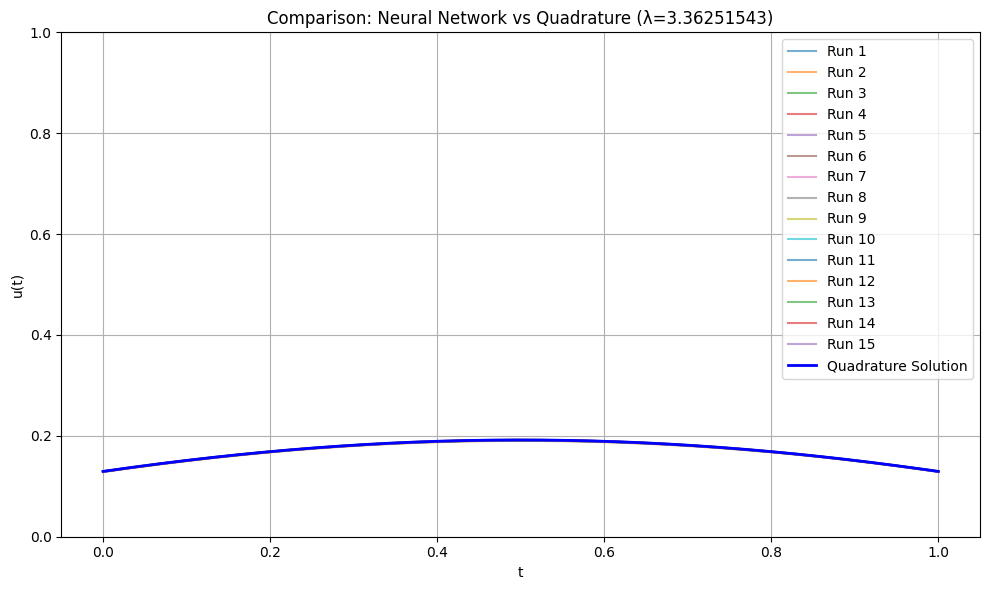

Running with layers [1, 32, 32, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 1
Number of failed models: 14
Average differences for with [1, 32, 32, 32, 32, 1] layers:
Average Difference: t=0: 0.00235681, t=0.5: 0.00335720, t=1: 0.00218229
Total Training Time for [1, 32, 32, 32, 32, 1]: 24.05 minutes, Average Train Time: 96.18 seconds


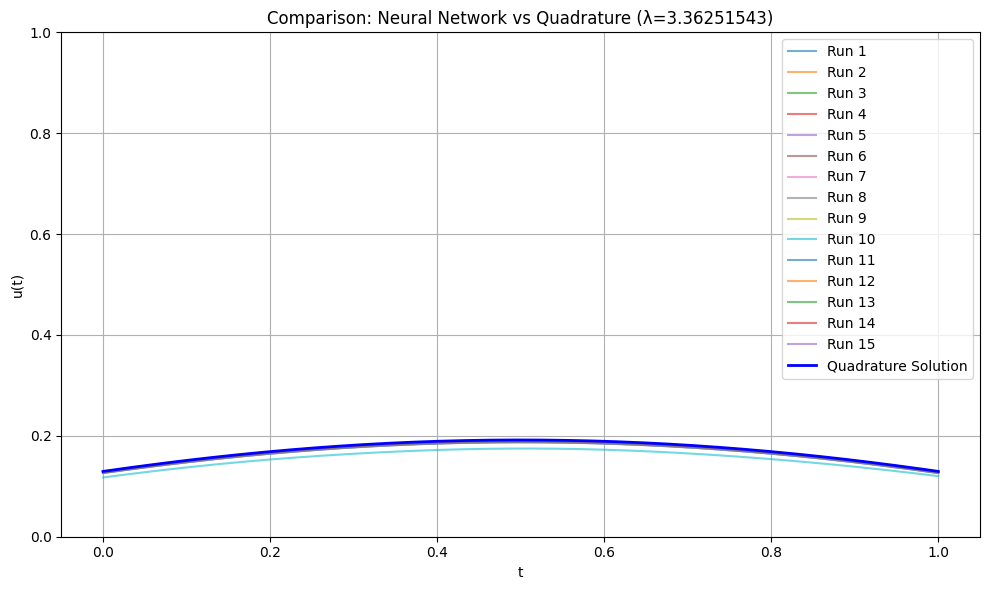

Running with layers [1, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 0
Number of failed models: 15
Average differences for with [1, 64, 64, 1] layers:
Average Difference: t=0: -0.00030530, t=0.5: -0.00031657, t=1: -0.00024679
Total Training Time for [1, 64, 64, 1]: 15.01 minutes, Average Train Time: 60.05 seconds


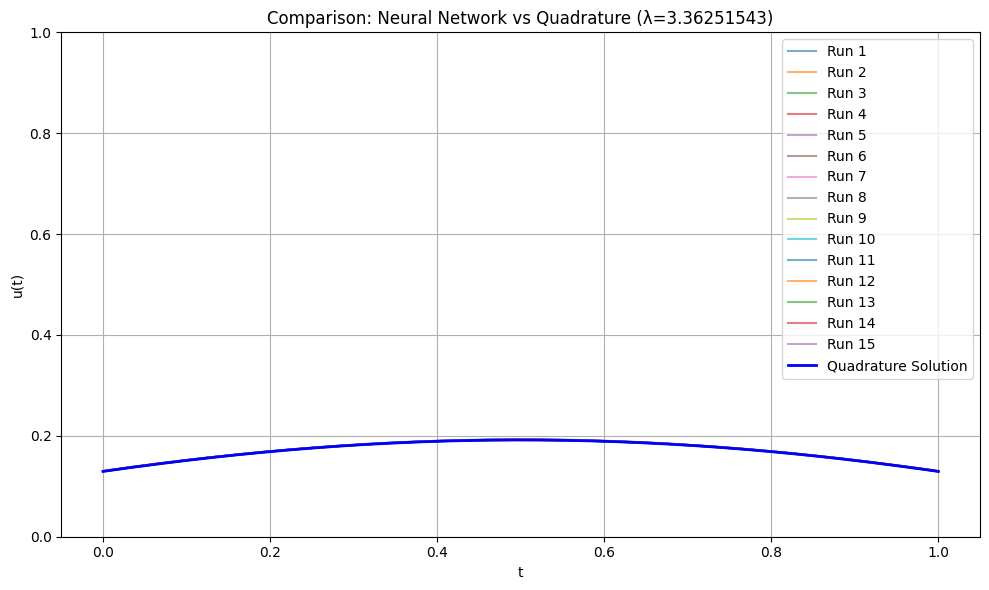

Running with layers [1, 64, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 2
Number of failed models: 13
Average differences for with [1, 64, 64, 64, 1] layers:
Average Difference: t=0: 0.00257404, t=0.5: 0.00360482, t=1: 0.00233076
Total Training Time for [1, 64, 64, 64, 1]: 19.62 minutes, Average Train Time: 78.48 seconds


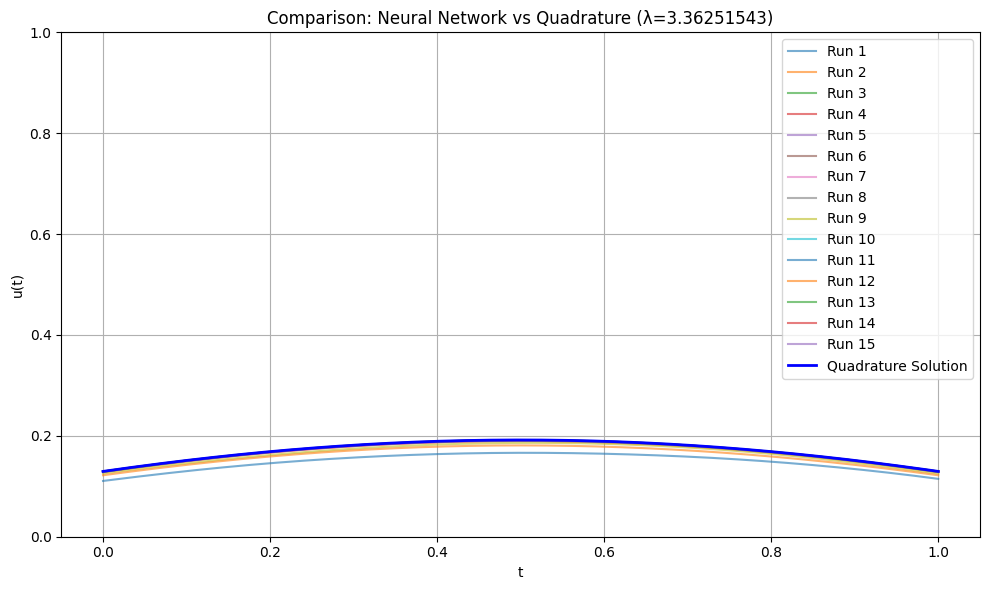

Running with layers [1, 64, 64, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 3
Number of failed models: 12
Average differences for with [1, 64, 64, 64, 64, 1] layers:
Average Difference: t=0: 0.00778072, t=0.5: 0.01265335, t=1: 0.00750395
Total Training Time for [1, 64, 64, 64, 64, 1]: 24.37 minutes, Average Train Time: 97.47 seconds


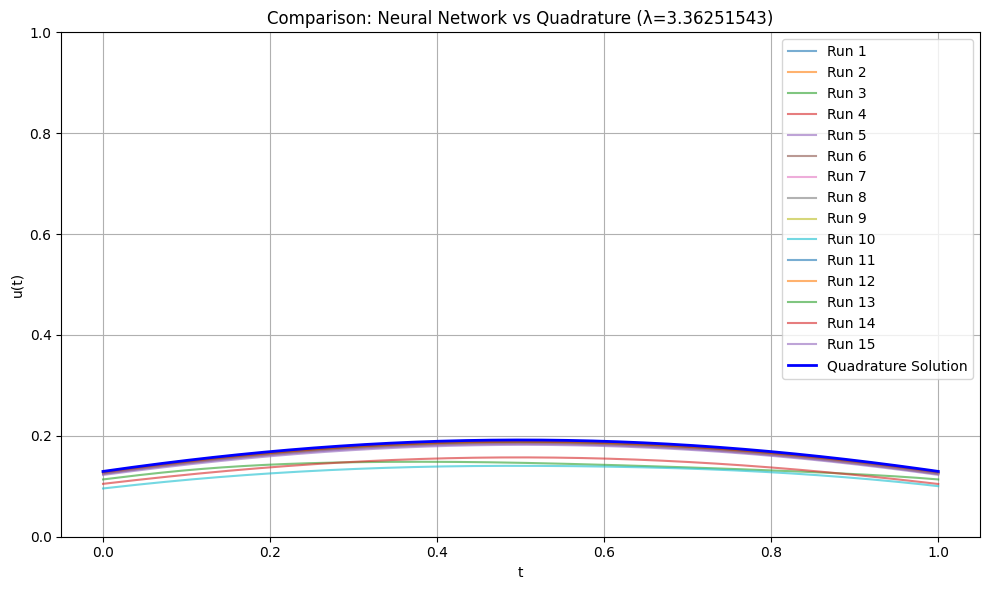

In [7]:
class CosActivation(nn.Module):
    def forward(self, x):
        return 0.5 * (1 - torch.cos(2 * np.pi * x))

# Step 1: Define the neural network
class Net(nn.Module):
    def __init__(self, layer_sizes=[1, 40, 60, 20, 1], activation=CosActivation, 
                 output_min=0.058579, output_max=0.259033):
        """
        Args:
            layer_sizes: List of integers defining the size of each layer.
                        First element is input size, last is output size.
                        Example: [1, 40, 60, 20, 1] creates 4 layers
            activation: Activation function class (e.g., nn.GELU, nn.ReLU)
            output_min: Minimum value for output scaling
            output_max: Maximum value for output scaling
        """
        super(Net, self).__init__()
        
        # Store scaling parameters
        self.output_min = output_min
        self.output_max = output_max
        
        # Build layers dynamically
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            # Add activation after all layers except the last
            if i < len(layer_sizes) - 2:
                layers.append(activation())
        
        self.hidden = nn.Sequential(*layers)
        self.output_activation = nn.Sigmoid()

    def forward(self, t):
        raw = self.hidden(t)
        return self.output_min + (self.output_max - self.output_min) * self.output_activation(raw)

# Step 4: Loss function
def loss_function(u_pred, t, net):
    u_t = u_pred  # u(t)

    # First derivative u'(t)
    u_t_grad = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]

    # Second derivative u''(t)
    u_t_grad2 = torch.autograd.grad(u_t_grad, t, torch.ones_like(u_t_grad), create_graph=True, allow_unused=True)[0]

    # Define the differential equation residual: -u''(t) - lambda*u(t)(1 - u(t))
    f = -u_t_grad2 - lambd * u_t * (1 - u_t)

    # Compute the loss for the differential equation
    loss_eq = torch.mean(f**2)

    # Enforce Robin boundary conditions
    t_0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True, device=device)
    t_1 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True, device=device)
    u_0 = net(t_0)
    u_1 = net(t_1)

    u_0_grad = torch.autograd.grad(u_0, t_0, torch.ones_like(u_0), create_graph=True)[0]
    u_1_grad = torch.autograd.grad(u_1, t_1, torch.ones_like(u_1), create_graph=True)[0]

    # Robin boundary conditions
    loss_bc_0 = ((-u_0_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_0) ** 2).mean()
    loss_bc_1 = ((u_1_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_1) ** 2).mean()

    return loss_eq, loss_bc_1, loss_bc_0

# Step 5: Define the training loop
def train_model(net, optimizer, layers, run_num, scheduler=None, n_epochs=3000):
    t_values = torch.linspace(0, 1, 500, device=device).view(-1, 1)
    t_values.requires_grad_()
    losses = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        u_pred = net(t_values)
        loss_eq, loss_bc_0, loss_bc_1 = loss_function(u_pred, t_values, net)

        total_loss = loss_eq + loss_bc_0 + loss_bc_1
    

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        if epoch % 500 == 0:
            losses.append(total_loss.item())
            layers_str = '_'.join(map(str, layers))
            filename = f'losses_layers_{layers_str}_run_{run_num}.txt'
            
            with open(filename, 'w') as f:
                f.write('epoch,loss\n')
                for e, l in enumerate(losses):
                    f.write(f'{e},{l}\n')

    # Fix: Add .cpu() before .numpy()
    return net(t_values).detach().cpu().numpy().flatten()

# Step 7: Grahping true solution using Quadrature
# Define F(u) and ODE
def F(u):
    return 0.5 * u**2 - (1/3) * u**3

def ode1(t, u, rho, lambd):
    val = 2 * lambd * (F(rho) - F(u))
    return np.sqrt(np.maximum(val, 0))

sol1 = solve_ivp(ode1, [0, 0.5], [u0], args=(rho, lambd), dense_output=True, rtol=1e-9, atol=1e-12)
t1 = np.linspace(0, 0.5, 100)
u1 = sol1.sol(t1)
t2 = 1 - t1
u2 = u1[:, ::-1]

t_quad = np.concatenate([t1, t2[::-1]])
u_quad = np.concatenate([u1.flatten(), u2.flatten()])

# 6. Run NN
N_RUNS = 15
t_test = np.linspace(0, 1, 500)

layer_sizes_configs = [
    [1, 40, 60, 20, 1],
    [1, 16, 16, 1],
    [1, 16, 16, 16, 1],
    [1, 16, 16, 16, 16, 1],
    [1, 32, 32, 1],
    [1, 32, 32, 32, 1],
    [1, 32, 32, 32, 32, 1],
    [1, 64, 64, 1],
    [1, 64, 64, 64, 1],
    [1, 64, 64, 64, 64, 1],
]

for layers in layer_sizes_configs:
    print(f"Running with layers {layers}")
    start_time = time.time()
    all_outputs = []
    passed_runs = 0
    failed_runs = 0

    for i in range(N_RUNS):
        net = Net(layer_sizes=layers, output_min=output_min, output_max=output_max).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        output = train_model(net, optimizer, layers, i+1, scheduler=None, n_epochs=5000)
        all_outputs.append(output)

        t_tensor = torch.tensor(t_test, dtype=torch.float32, device=device).unsqueeze(1)
        u_pred_test = net(t_tensor).detach().cpu().numpy().flatten()
        idx_05 = np.argmin(np.abs(t_test - 0.5))

        if abs(rho - u_pred_test[idx_05]) > 1e-2:
            passed_runs += 1

        else:
            failed_runs += 1

        print(f"Run: {i + 1} / {N_RUNS}")

    print(f"Number of passed models: {passed_runs}")
    print(f"Number of failed models: {failed_runs}")
    print("=" * 60)

    all_outputs = np.array(all_outputs)

    # Compute average differences at t=0, t=0.5, t=1
    diffs_0 = []
    diffs_05 = []
    diffs_1 = []

    for i in range(N_RUNS):
        output = all_outputs[i]
        diffs_0.append(u0 - output[0])
        diffs_05.append(rho - output[idx_05])
        diffs_1.append(u0 - output[-1])

    avg_diff_0 = np.mean(diffs_0)
    avg_diff_05 = np.mean(diffs_05)
    avg_diff_1 = np.mean(diffs_1)

    print(f"Average differences for with {layers} layers:")
    print(f"Average Difference: t=0: {avg_diff_0:.8f}, t=0.5: {avg_diff_05:.8f}, t=1: {avg_diff_1:.8f}")
    end_time = time.time()
    elapsed = end_time - start_time
    ave_elap = elapsed / N_RUNS
    elap_min = elapsed / 60
    print(f"Total Training Time for {layers}: {elap_min:.2f} minutes, Average Train Time: {ave_elap:.2f} seconds")
    print("=" * 60)

    # Plot Mean and Variance
    plt.figure(figsize=(10, 6))
    for i, output in enumerate(all_outputs):
        plt.plot(t_test, output, label=f'Run {i+1}', alpha=0.6)
    plt.plot(t_quad, u_quad, label="Quadrature Solution", color="blue", linewidth=2)
    plt.title(f"Comparison: Neural Network vs Quadrature (λ={lambd})")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
# Parameters
lambd = 35.26398748
rho = 0.92653061
u0 = 0.43838751
gamma1 = 1
output_min35=0.156112
output_max35=2.256968

Running with layers [1, 40, 60, 20, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 40, 60, 20, 1] layers:
Average Difference: t=0: 0.37852358, t=0.5: 0.86791820, t=1: 0.37851306
Total Training Time for [1, 40, 60, 20, 1]: 19.59 minutes, Average Train Time: 78.37 seconds


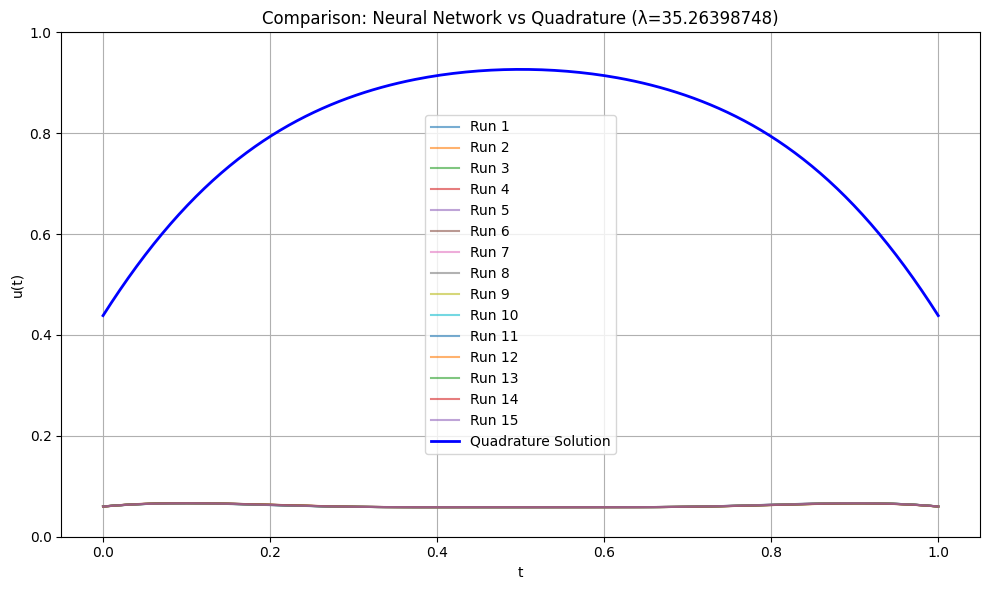

Running with layers [1, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 16, 16, 1] layers:
Average Difference: t=0: 0.37728058, t=0.5: 0.86790688, t=1: 0.37727036
Total Training Time for [1, 16, 16, 1]: 14.97 minutes, Average Train Time: 59.88 seconds


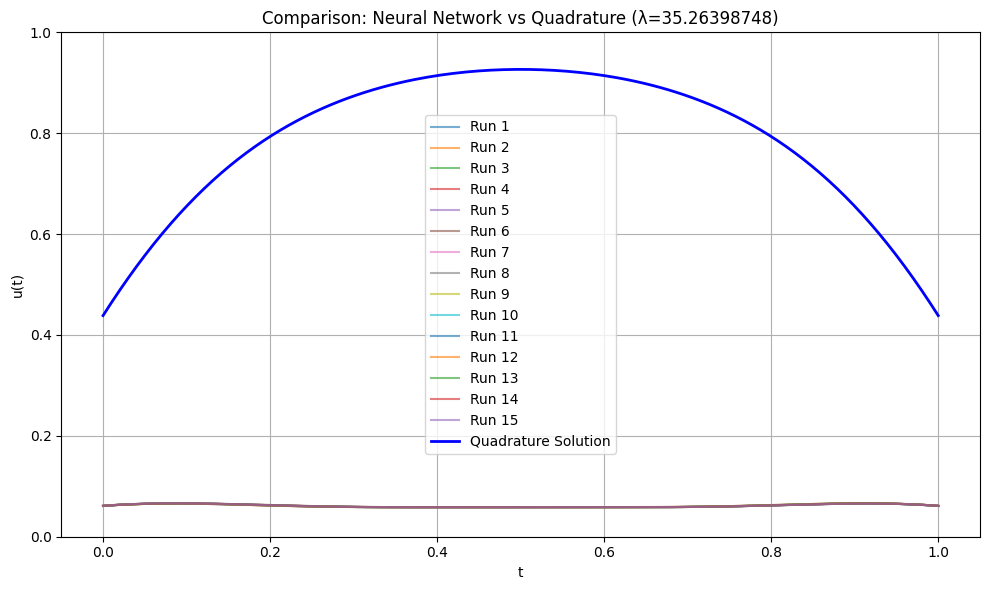

Running with layers [1, 16, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 16, 16, 16, 1] layers:
Average Difference: t=0: 0.37831593, t=0.5: 0.86790895, t=1: 0.37831740
Total Training Time for [1, 16, 16, 16, 1]: 19.48 minutes, Average Train Time: 77.93 seconds


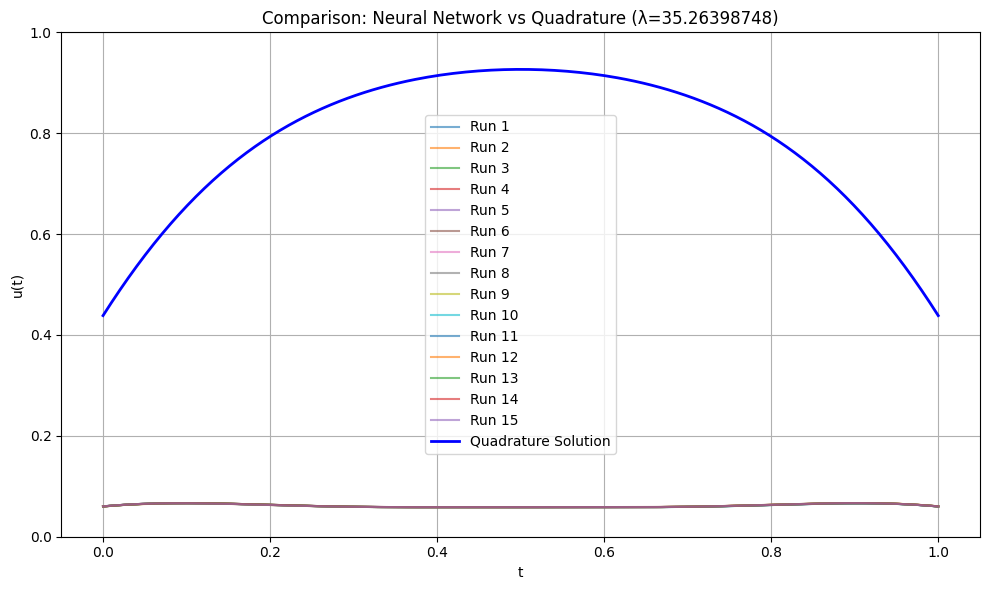

Running with layers [1, 16, 16, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 16, 16, 16, 16, 1] layers:
Average Difference: t=0: 0.37879068, t=0.5: 0.86788364, t=1: 0.37883142
Total Training Time for [1, 16, 16, 16, 16, 1]: 24.20 minutes, Average Train Time: 96.79 seconds


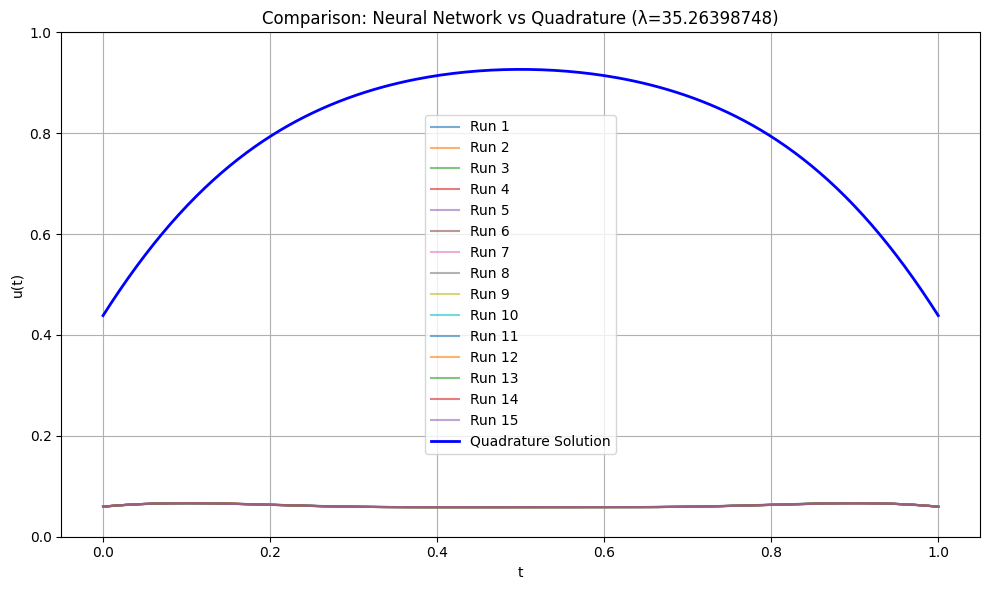

Running with layers [1, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 32, 32, 1] layers:
Average Difference: t=0: 0.37745716, t=0.5: 0.86793969, t=1: 0.37744129
Total Training Time for [1, 32, 32, 1]: 14.95 minutes, Average Train Time: 59.79 seconds


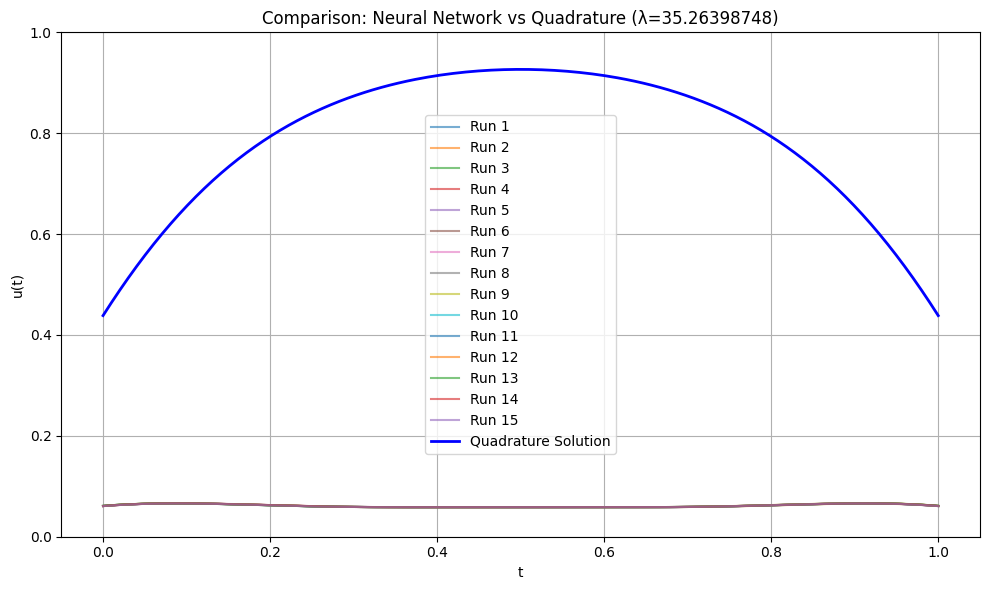

Running with layers [1, 32, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 32, 32, 32, 1] layers:
Average Difference: t=0: 0.37855204, t=0.5: 0.86793247, t=1: 0.37852302
Total Training Time for [1, 32, 32, 32, 1]: 19.41 minutes, Average Train Time: 77.65 seconds


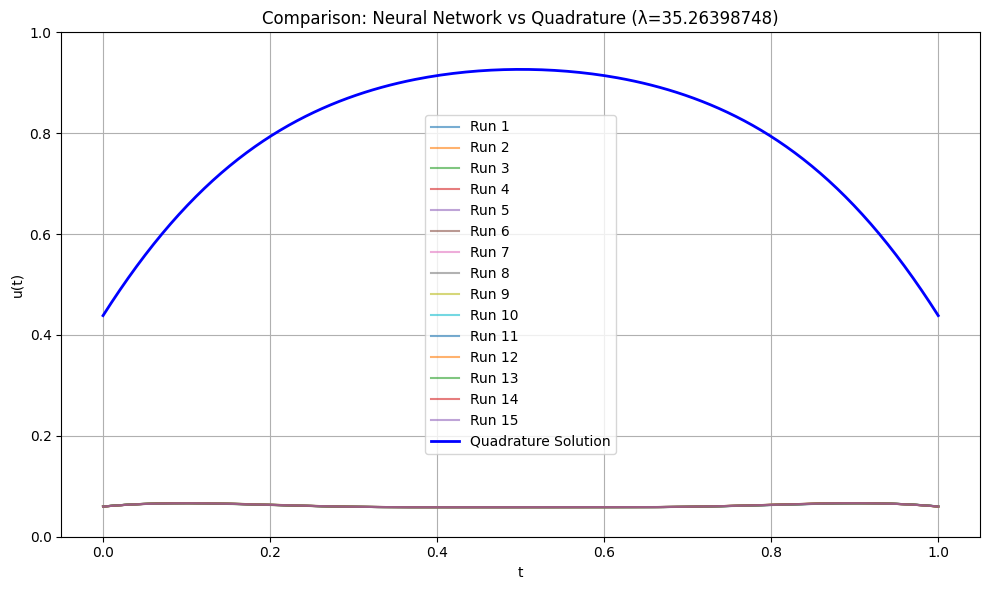

Running with layers [1, 32, 32, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 32, 32, 32, 32, 1] layers:
Average Difference: t=0: 0.37889022, t=0.5: 0.86792754, t=1: 0.37879775
Total Training Time for [1, 32, 32, 32, 32, 1]: 24.41 minutes, Average Train Time: 97.62 seconds


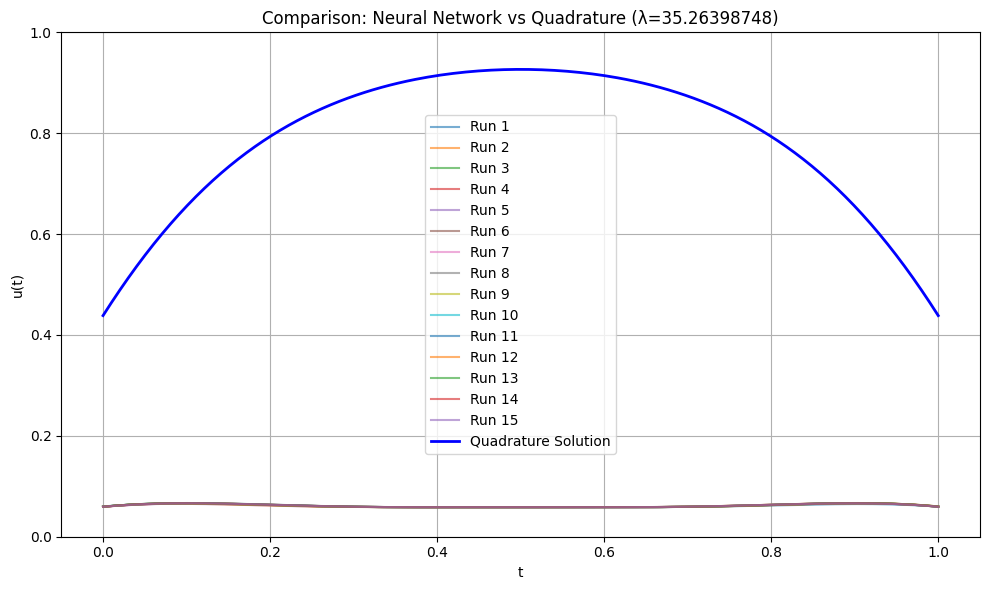

Running with layers [1, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 64, 64, 1] layers:
Average Difference: t=0: 0.37765580, t=0.5: 0.86794927, t=1: 0.37764293
Total Training Time for [1, 64, 64, 1]: 15.04 minutes, Average Train Time: 60.17 seconds


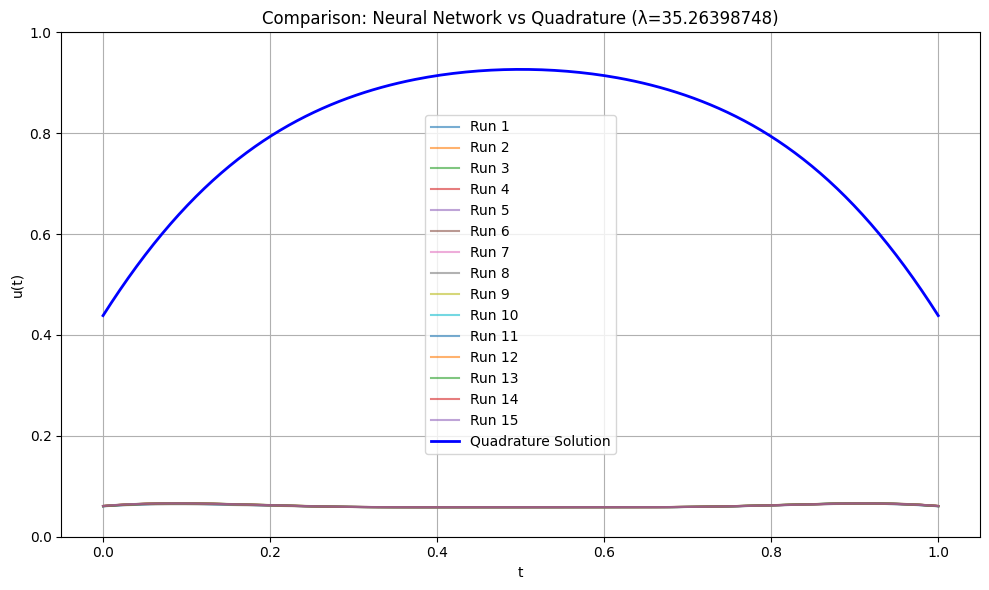

Running with layers [1, 64, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 64, 64, 64, 1] layers:
Average Difference: t=0: 0.37873434, t=0.5: 0.86794170, t=1: 0.37875175
Total Training Time for [1, 64, 64, 64, 1]: 19.50 minutes, Average Train Time: 78.00 seconds


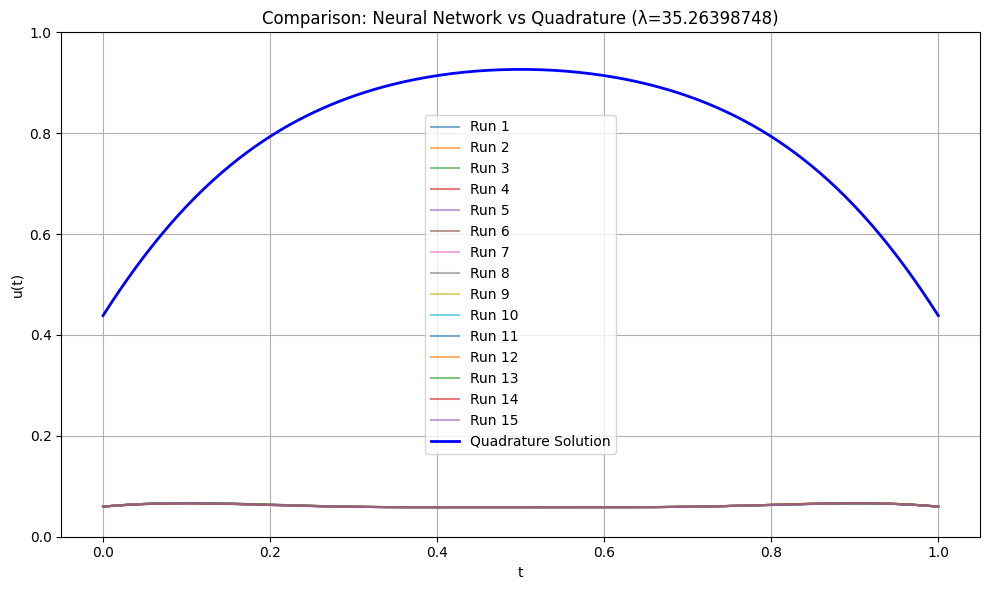

Running with layers [1, 64, 64, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 64, 64, 64, 64, 1] layers:
Average Difference: t=0: 0.37869528, t=0.5: 0.86793548, t=1: 0.37888636
Total Training Time for [1, 64, 64, 64, 64, 1]: 24.35 minutes, Average Train Time: 97.41 seconds


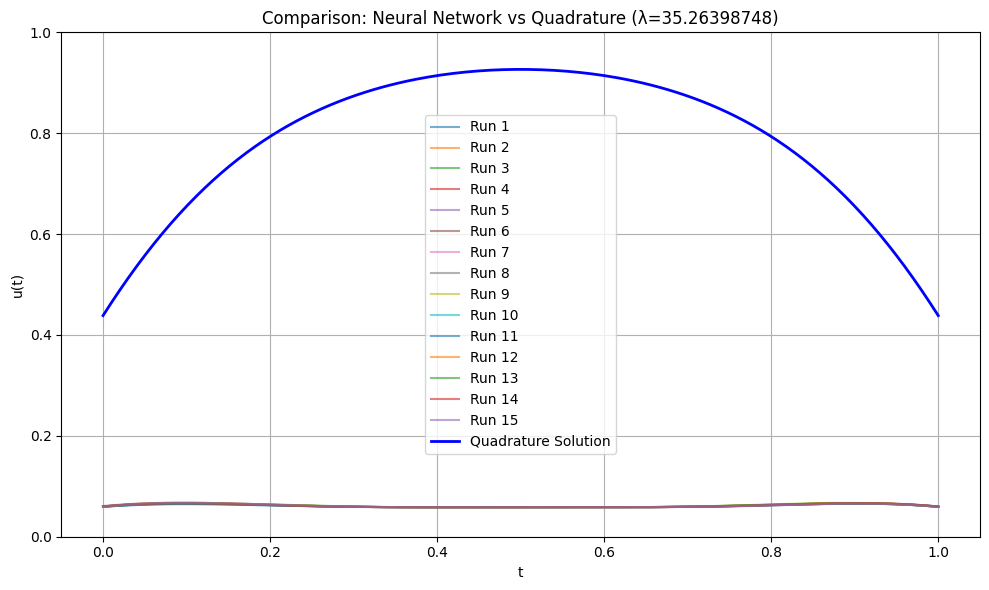

In [9]:

class CosActivation(nn.Module):
    def forward(self, x):
        return 0.5 * (1 - torch.cos(2 * np.pi * x))

# Step 1: Define the neural network
class Net(nn.Module):
    def __init__(self, layer_sizes=[1, 40, 60, 20, 1], activation=CosActivation, 
                 output_min=0.156112, output_max=2.256968):
        """
        Args:
            layer_sizes: List of integers defining the size of each layer.
                        First element is input size, last is output size.
                        Example: [1, 40, 60, 20, 1] creates 4 layers
            activation: Activation function class (e.g., nn.GELU, nn.ReLU)
            output_min: Minimum value for output scaling
            output_max: Maximum value for output scaling
        """
        super(Net, self).__init__()
        
        # Store scaling parameters
        self.output_min = output_min
        self.output_max = output_max
        
        # Build layers dynamically
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            # Add activation after all layers except the last
            if i < len(layer_sizes) - 2:
                layers.append(activation())
        
        self.hidden = nn.Sequential(*layers)
        self.output_activation = nn.Sigmoid()

    def forward(self, t):
        raw = self.hidden(t)
        return self.output_min + (self.output_max - self.output_min) * self.output_activation(raw)

# Step 4: Loss function
def loss_function(u_pred, t, net):
    u_t = u_pred  # u(t)

    # First derivative u'(t)
    u_t_grad = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]

    # Second derivative u''(t)
    u_t_grad2 = torch.autograd.grad(u_t_grad, t, torch.ones_like(u_t_grad), create_graph=True, allow_unused=True)[0]

    # Define the differential equation residual: -u''(t) - lambda*u(t)(1 - u(t))
    f = -u_t_grad2 - lambd * u_t * (1 - u_t)

    # Compute the loss for the differential equation
    loss_eq = torch.mean(f**2)

    # Enforce Robin boundary conditions
    t_0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True, device=device)
    t_1 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True, device=device)
    u_0 = net(t_0)
    u_1 = net(t_1)

    u_0_grad = torch.autograd.grad(u_0, t_0, torch.ones_like(u_0), create_graph=True)[0]
    u_1_grad = torch.autograd.grad(u_1, t_1, torch.ones_like(u_1), create_graph=True)[0]

    # Robin boundary conditions
    loss_bc_0 = ((-u_0_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_0) ** 2).mean()
    loss_bc_1 = ((u_1_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_1) ** 2).mean()

    return loss_eq, loss_bc_1, loss_bc_0

# Step 5: Define the training loop
def train_model(net, optimizer, layers, run_num, scheduler=None, n_epochs=3000):
    t_values = torch.linspace(0, 1, 500, device=device).view(-1, 1)
    t_values.requires_grad_()
    losses = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        u_pred = net(t_values)
        loss_eq, loss_bc_0, loss_bc_1 = loss_function(u_pred, t_values, net)

        total_loss = loss_eq + loss_bc_0 + loss_bc_1

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        if epoch % 500 == 0:
            losses.append(total_loss.item())
            layers_str = '_'.join(map(str, layers))
            filename = f'losses_layers_{layers_str}_run_{run_num}.txt'
            
            with open(filename, 'w') as f:
                f.write('epoch,loss\n')
                for e, l in enumerate(losses):
                    f.write(f'{e},{l}\n')

    # Fix: Add .cpu() before .numpy()
    return net(t_values).detach().cpu().numpy().flatten()

# Step 7: Grahping true solution using Quadrature
# Define F(u) and ODE
def F(u):
    return 0.5 * u**2 - (1/3) * u**3

def ode1(t, u, rho, lambd):
    val = 2 * lambd * (F(rho) - F(u))
    return np.sqrt(np.maximum(val, 0))

sol1 = solve_ivp(ode1, [0, 0.5], [u0], args=(rho, lambd), dense_output=True, rtol=1e-9, atol=1e-12)
t1 = np.linspace(0, 0.5, 100)
u1 = sol1.sol(t1)
t2 = 1 - t1
u2 = u1[:, ::-1]

t_quad = np.concatenate([t1, t2[::-1]])
u_quad = np.concatenate([u1.flatten(), u2.flatten()])

# 6. Run NN
N_RUNS = 15
t_test = np.linspace(0, 1, 500)

layer_sizes_configs = [
    [1, 40, 60, 20, 1],
    [1, 16, 16, 1],
    [1, 16, 16, 16, 1],
    [1, 16, 16, 16, 16, 1],
    [1, 32, 32, 1],
    [1, 32, 32, 32, 1],
    [1, 32, 32, 32, 32, 1],
    [1, 64, 64, 1],
    [1, 64, 64, 64, 1],
    [1, 64, 64, 64, 64, 1],
]

for layers in layer_sizes_configs:
    print(f"Running with layers {layers}")
    start_time = time.time()
    all_outputs = []
    passed_runs = 0
    failed_runs = 0

    for i in range(N_RUNS):
        net = Net(layer_sizes=layers, output_min=output_min, output_max=output_max).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        output = train_model(net, optimizer, layers, i+1, scheduler=None, n_epochs=5000)
        all_outputs.append(output)

        t_tensor = torch.tensor(t_test, dtype=torch.float32, device=device).unsqueeze(1)
        u_pred_test = net(t_tensor).detach().cpu().numpy().flatten()
        idx_05 = np.argmin(np.abs(t_test - 0.5))

        if abs(rho - u_pred_test[idx_05]) > 1e-2:
            passed_runs += 1

        else:
            failed_runs += 1

        print(f"Run: {i + 1} / {N_RUNS}")

    print(f"Number of passed models: {passed_runs}")
    print(f"Number of failed models: {failed_runs}")
    print("=" * 60)

    all_outputs = np.array(all_outputs)

    # Compute average differences at t=0, t=0.5, t=1
    diffs_0 = []
    diffs_05 = []
    diffs_1 = []

    for i in range(N_RUNS):
        output = all_outputs[i]
        diffs_0.append(u0 - output[0])
        diffs_05.append(rho - output[idx_05])
        diffs_1.append(u0 - output[-1])

    avg_diff_0 = np.mean(diffs_0)
    avg_diff_05 = np.mean(diffs_05)
    avg_diff_1 = np.mean(diffs_1)

    print(f"Average differences for with {layers} layers:")
    print(f"Average Difference: t=0: {avg_diff_0:.8f}, t=0.5: {avg_diff_05:.8f}, t=1: {avg_diff_1:.8f}")
    end_time = time.time()
    elapsed = end_time - start_time
    ave_elap = elapsed / N_RUNS
    elap_min = elapsed / 60
    print(f"Total Training Time for {layers}: {elap_min:.2f} minutes, Average Train Time: {ave_elap:.2f} seconds")
    print("=" * 60)

    # Plot Mean and Variance
    plt.figure(figsize=(10, 6))
    for i, output in enumerate(all_outputs):
        plt.plot(t_test, output, label=f'Run {i+1}', alpha=0.6)
    plt.plot(t_quad, u_quad, label="Quadrature Solution", color="blue", linewidth=2)
    plt.title(f"Comparison: Neural Network vs Quadrature (λ={lambd})")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()